<a href="https://colab.research.google.com/github/javistumpf/reviewshoteles/blob/main/Proyecto_final_DF_III_Stumpf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento de lenguaje natural - Reviews de hoteles

# 📝 Overview

### 🏨 Sobre el proyecto
Andalusian Hotel Reviews Corpus (AHR) es un conjunto de datos que contiene 7.615 reseñas de hoteles en español, correspondientes a opiniones de usuarios sobre su experiencia en hoteles de Andalucía. Cada reseña incluye un título, el texto de la opinión, la calificación otorgada en una escala de 1 a 5 estrellas, además de información sobre la ubicación y el nombre del hotel (cuando está disponible).

Este corpus es útil para diversas tareas de procesamiento de lenguaje natural (PLN), como clasificación de sentimientos, análisis de polaridad, predicción de calificaciones y modelado de temas, especialmente en el contexto del idioma español.

### 🧭 Contexto

La Secretaría de Turismo de Andalucía busca fortalecer su estrategia de promoción y mejora de la experiencia turística en la región. Para ello, es clave comprender la percepción que los visitantes tienen sobre los alojamientos en el territorio andaluz. En un contexto donde las decisiones de viaje están fuertemente influenciadas por las opiniones en línea, las reseñas de usuarios en plataformas digitales se presentan como una fuente rica de información para analizar la calidad percibida, detectar problemáticas recurrentes y destacar fortalezas del sector hotelero.

### 🎯 Objetivo

El presente proyecto tiene como finalidad analizar y modelar la experiencia de los visitantes en alojamientos turísticos de Andalucía a partir de reseñas públicas disponibles en línea. El análisis se enfoca en:

- Entender la distribución y percepción general de los hoteles.

- Identificar los aspectos más valorados (positivos y negativos) por los huéspedes.

- Evaluar la satisfacción mediante análisis de sentimientos automatizados.

- Detectar patrones que puedan orientar mejoras en la calidad de los servicios turísticos.

# 🗂️ Importación de librerías y de la base de datos

In [103]:
!pip install -U spacy
!python -m spacy download es_core_news_sm
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 125.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import spacy
import unicodedata
nlp = spacy.load("es_core_news_sm")
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from tqdm import tqdm
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


In [105]:
# Importación de la base de datos
url = "https://drive.google.com/uc?id="
ext = "1sbHFj02oFo_Ax70G-GIAFG4hmQGHAqQi"
hoteles_original_df = pd.read_csv(url+ext)

In [106]:
# Copia de la base de datos para trabajar
hoteles_df = hoteles_original_df.copy()

In [107]:
# Exploración de los primeros 5 registros
hoteles_df.head()

,Unnamed: 0,title,rating,review_text,location,hotel,label
0,0,IMPOSIBLE DESCANSAR,2,El fin de semana mi pareja y yo hicimos una re...,Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,0
1,1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiacione...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3
2,2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no ...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,3
3,3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se coment...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0
4,4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,0


# 🛠️Preprocesamiento y limpieza de datos

### Limpieza de columnas que no forman parte del análisis

In [108]:
# Eliminación de columnas 'Unnamed: 0' y 'label'
hoteles_df = hoteles_df.drop(columns=['Unnamed: 0', 'label'])

Se detectaron columnas que no aportan sentido al análisis y por ello se eliminaron.

In [109]:
# Exploración de las columnas: nulos y tipos de datos
hoteles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7615 entries, 0 to 7614
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        7615 non-null   object
 1   rating       7615 non-null   int64 
 2   review_text  7615 non-null   object
 3   location     6819 non-null   object
 4   hotel        6819 non-null   object
dtypes: int64(1), object(4)
memory usage: 297.6+ KB


Se detectaron 796 casos de reseñas sin hotel. Al ser un 10,4% de los datos y, como el análisis es global (no por hotel), dichas reseñas serán tenidas en cuenta para el análisis.

### Creación de una columna unificada entre title y review_text

In [110]:
# Concatenación de las columnas title y review text
hoteles_df['full_review'] = hoteles_df['title'] + '. ' + hoteles_df['review_text']

In [111]:
# Revisión de la correcta creación de la columna full_review
hoteles_df.head()

,title,rating,review_text,location,hotel,full_review
0,IMPOSIBLE DESCANSAR,2,El fin de semana mi pareja y yo hicimos una re...,Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,IMPOSIBLE DESCANSAR. El fin de semana mi parej...
1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiacione...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,No es oro todo lo que reluce. El hotel en gene...
2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no ...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,Un buen hotel con mucho ruido.. El hotel es mo...
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se coment...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO. Calefacc...
4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,Deja bastante que desear.. Este hotel ha bajad...


Hasta el momento se ha cargado la información de las reseñas de los hoteles. Se han eliminado columnas que no aportan valor al análisis y se ha tomado la decisión de no descartar los registros con valores vacíos en el campo hotel.

Como forma de facilitar el paso siguiente, se ha creado una única columna con el título de la reseña y el texto de misma.

### Limpieza de texto para NLP

In [112]:
# Creación de la función para limpiar texto
def limpiar_texto(texto):
    # Convertir a string por si hay valores no textuales
    texto = str(texto)
    # Normalizar caracteres Unicode
    texto = unicodedata.normalize("NFC", texto)

    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)

    # Eliminar etiquetas HTML
    texto = re.sub(r'<.*?>', '', texto)

    # Eliminar signos de puntuación
    texto = texto.translate(str.maketrans('', '', string.punctuation))

    # Eliminar saltos de línea y espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()

    # Eliminar palabras que contienen números
    texto = re.sub(r'\w*\d\w*', '', texto)

    # Eliminar caracteres especiales no alfabéticos
    texto = re.sub(r'[^a-záééíóúñü\s]', '', texto)

    return texto

In [113]:
# Aplicación de la función al dataframe, creando una nueva columna: full_review_limpia
hoteles_df['full_review_limpia'] = hoteles_df['full_review'].apply(limpiar_texto)

In [114]:
# Revisión de la correcta creación de la columna
hoteles_df.head()

,title,rating,review_text,location,hotel,full_review,full_review_limpia
0,IMPOSIBLE DESCANSAR,2,El fin de semana mi pareja y yo hicimos una re...,Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,IMPOSIBLE DESCANSAR. El fin de semana mi parej...,imposible descansar el fin de semana mi pareja...
1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiacione...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,No es oro todo lo que reluce. El hotel en gene...,no es oro todo lo que reluce el hotel en gener...
2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no ...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,Un buen hotel con mucho ruido.. El hotel es mo...,un buen hotel con mucho ruido el hotel es mode...
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se coment...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO. Calefacc...,sin calefacción operativa y con frío calefacci...
4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,Deja bastante que desear.. Este hotel ha bajad...,deja bastante que desear este hotel ha bajado ...


### tokenización + stopwords + lematización

In [115]:
# Lista de lemas personalizados a eliminar
stopwords_extra = {
     "él", "él","hotel", "habitación", "reserva", "tener", "sevilla", "barrio", "santa", "cruz", "noche", "lugar", "llegar", "pasar"
}

# Unificación de ambas listas de stopwords como conjunto de lemas
stopwords_lemas = STOP_WORDS.union(stopwords_extra)

# Función de Lematización y eliminación de stopwords
def procesar_texto(texto):
    doc = nlp(texto)
    return ' '.join([
        token.lemma_ for token in doc
        if token.lemma_.lower() not in stopwords_lemas and not token.is_punct and not token.is_space
    ])

In [116]:
# Aplicación de la función de lematización y eliminación de stopwords
hoteles_df['review_procesada'] = hoteles_df['full_review_limpia'].apply(procesar_texto)

In [117]:
# Revisión de la correcta creación de la columna review_procesada
hoteles_df.head()

,title,rating,review_text,location,hotel,full_review,full_review_limpia,review_procesada
0,IMPOSIBLE DESCANSAR,2,El fin de semana mi pareja y yo hicimos una re...,Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,IMPOSIBLE DESCANSAR. El fin de semana mi parej...,imposible descansar el fin de semana mi pareja...,imposible descansar semana pareja descansar de...
1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiacione...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,No es oro todo lo que reluce. El hotel en gene...,no es oro todo lo que reluce el hotel en gener...,oro relucir general habtiación espaciosa perso...
2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no ...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,Un buen hotel con mucho ruido.. El hotel es mo...,un buen hotel con mucho ruido el hotel es mode...,ruido moderno amplio limpio disfrutar experien...
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se coment...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO. Calefacc...,sin calefacción operativa y con frío calefacci...,calefacción operativo frío calefacción averiad...
4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,Deja bastante que desear.. Este hotel ha bajad...,deja bastante que desear este hotel ha bajado ...,dejar desear bajar notoriamente categoria host...


In [118]:
# Creación de lista Reviews
reviews = hoteles_df['review_procesada'].dropna().astype(str).tolist()

### Lematización de adjetivos

In [119]:
# Creación de función para extraer adjetivos
def extraer_adjetivos(texto):
    doc = nlp(texto)
    return [token.lemma_ for token in doc if token.pos_ == "ADJ"]

In [120]:
# Aplicación de la función para extraer adjetivos
hoteles_df['adjetivos'] = hoteles_df['full_review_limpia'].apply(extraer_adjetivos)

In [121]:
# Aplanación la lista de listas
todos_los_adjetivos = [adj for lista in hoteles_df['adjetivos'] for adj in lista]

Se aplicaron técnicas de normalización de texto que incluyeron la conversión a minúsculas, eliminación de signos de puntuación, caracteres especiales, números y espacios redundantes. Además, se removieron stopwords que no aportan valor al análisis, y se aplicaron técnicas de lemmatización para reducir las palabras a su forma base, conservando así el significado original del mensaje.

Este preprocesamiento permitió estandarizar los datos y reducir el ruido textual, lo cual facilita una interpretación más precisa de los patrones lingüísticos y asegura la robustez de los modelos de procesamiento del lenguaje natural (NLP) utilizados posteriormente.

# 🔍 Análisis exploratorio de datos (EDA)

### Panorama General de la Oferta Hotelera en Andalucía

In [122]:
# Cantidad de hoteles
cantidad_hoteles = hoteles_df['hotel'].nunique()
print(f"Cantidad de hoteles: {cantidad_hoteles}")

Cantidad de hoteles: 582


In [123]:
# Cantidad de reseñas por hotel
reseñas_hoteles = hoteles_df['hotel'].value_counts()
reseñas_hoteles

,count
hotel,
Hotel_Xauen,64
Hotel_Infanta_Cristina,52
Hotel_Condestable_Iranzo,48
Hotel_Gravina51,40
Joya_Del_Casco_Boutique_Hotel,40
...,...
Lights_Out_Suites,1
Hotel_Plaza_Escribano,1
Iberos,1


In [164]:
# Promedio de reseñas por hotel
promedio_reseñas = hoteles_df['hotel'].value_counts().mean()
print(f"Promedio de reseñas por hotel: {promedio_reseñas:.2f}")

Promedio de reseñas por hotel: 11.72


In [124]:
# Cantidad de ciudades
cantidad_ciudades = hoteles_df['location'].nunique()
print(f"Cantidad de ciudades: {cantidad_ciudades}")

Cantidad de ciudades: 21


En el presente proyecto se evalúan un total de 582 hoteles de 21 ciudades de Andalucía. Cada hotel tiene entre 1 y 64 reseñas (en promedio 12 reseñas por hotel).


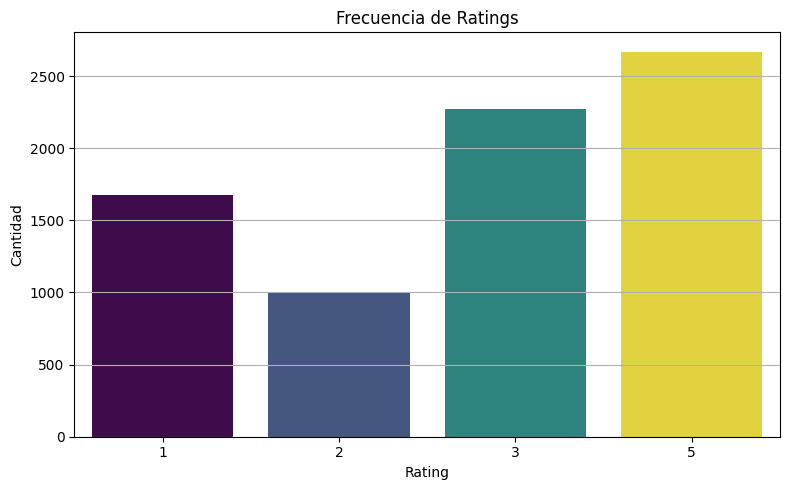

In [125]:
# Frecuencia de ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=hoteles_df, x='rating', hue='rating', palette='viridis', legend=False, order=sorted(hoteles_df['rating'].dropna().unique()))
plt.title('Frecuencia de Ratings')
plt.xlabel('Rating')
plt.ylabel('Cantidad')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [126]:
# Promedio y desviación estándar del rating
hoteles_df['rating'].describe()

,rating
count,7615.000000
mean,3.130269
std,1.548310
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,5.000000


Se observa mayor cantidad de reseñas con rating 5. No se detectaron valores de calificación 4. Entre las reseñas de calificación 1 y 2, se equiparan a las positivas. Se puede decir que las calificaciones agrupadas extremas (positivo/ negativo) se encuentran balanceadas y existe un leve desbalance hacia las calificaciones neutras.
En promedio, el rating es 3,13, con una desviación estándar baja (1,54).

### Exploración de lenguaje y temáticas frecuentes

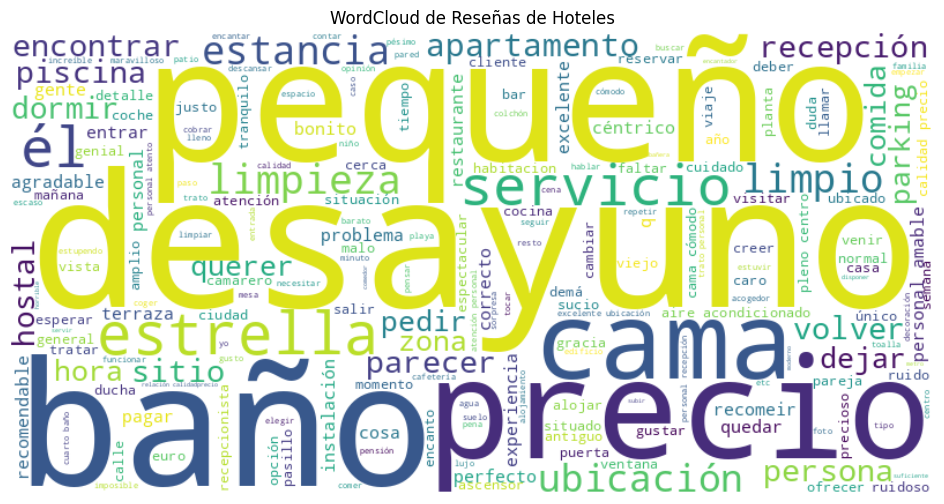

In [127]:
# Wordcloud general
texto_total = ' '.join(reviews)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_total)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud de Reseñas de Hoteles')
plt.show()

/tmp/ipython-input-128-1600030213.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




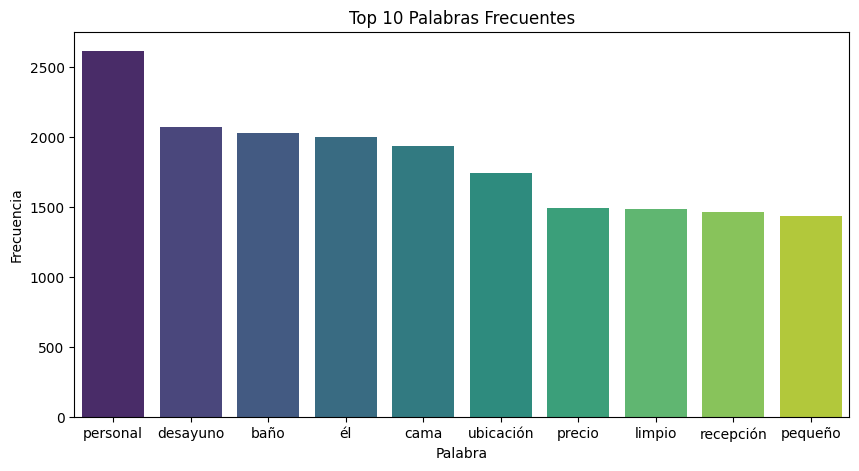

In [128]:
# Palabras frecuentes
palabras = texto_total.split()
conteo = Counter(palabras)
top_words = conteo.most_common(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=[palabra for palabra, _ in top_words], y=[frecuencia for _, frecuencia in top_words], palette='viridis')
plt.title('Top 10 Palabras Frecuentes')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.show()

/tmp/ipython-input-129-335654303.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




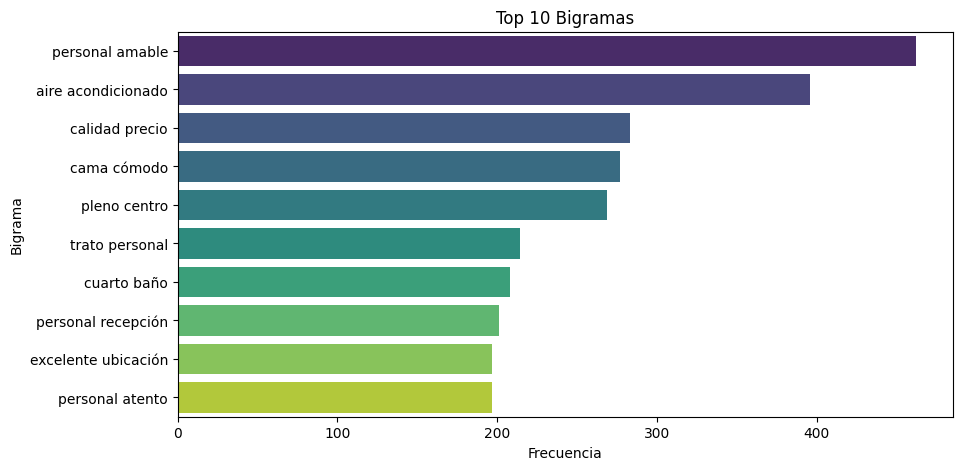

In [129]:
# Bigramas
vectorizer_bi = CountVectorizer(ngram_range=(2, 2))
X_bi = vectorizer_bi.fit_transform(reviews)
bigrama_freq = zip(vectorizer_bi.get_feature_names_out(), X_bi.toarray().sum(axis=0))
top_bigrams = sorted(bigrama_freq, key=lambda x: x[1], reverse=True)[:10]

bigrams_df = pd.DataFrame(top_bigrams, columns=["Bigrama", "Frecuencia"])
plt.figure(figsize=(10, 5))
sns.barplot(data=bigrams_df, x='Frecuencia', y='Bigrama', palette='viridis')
plt.title('Top 10 Bigramas')
plt.show()

/tmp/ipython-input-130-3480451902.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




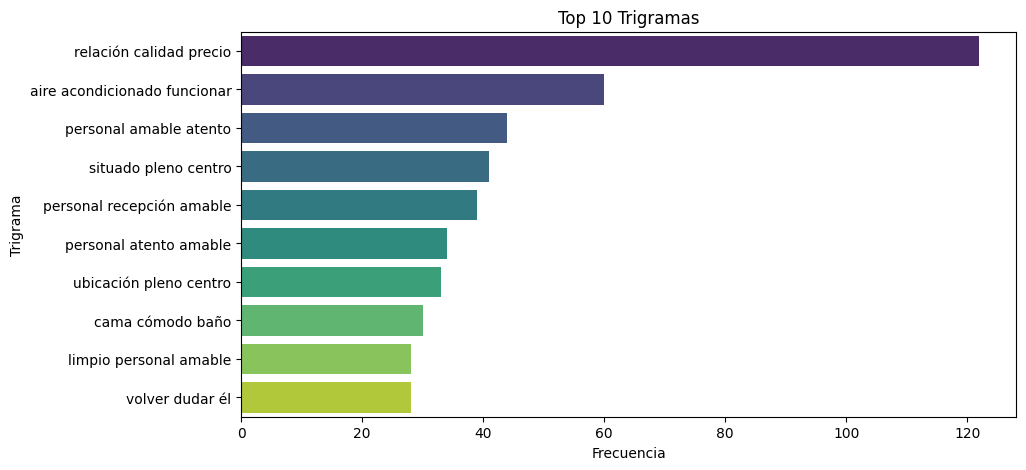

In [130]:
# Trigramas
vectorizer_tri = CountVectorizer(ngram_range=(3, 3))
X_tri = vectorizer_tri.fit_transform(reviews)
trigrama_freq = zip(vectorizer_tri.get_feature_names_out(), X_tri.toarray().sum(axis=0))
top_trigrams = sorted(trigrama_freq, key=lambda x: x[1], reverse=True)[:10]

trigrams_df = pd.DataFrame(top_trigrams, columns=["Trigrama", "Frecuencia"])
plt.figure(figsize=(10, 5))
sns.barplot(data=trigrams_df, x='Frecuencia', y='Trigrama', palette='viridis')
plt.title('Top 10 Trigramas')
plt.show()

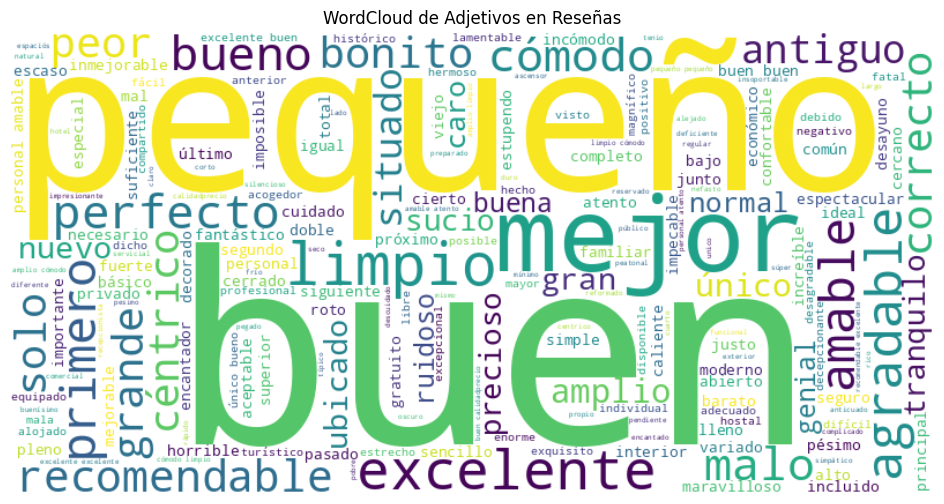

In [131]:
# Wordcloud de adjetivos
texto_adjetivos = ' '.join(todos_los_adjetivos)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_adjetivos)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud de Adjetivos en Reseñas')
plt.show()

### Análisis de sentimientos

In [132]:


# Cargar modelo y tokenizer
modelo_id = "finiteautomata/beto-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(modelo_id)

# Crear pipeline con truncamiento activado
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=modelo_id,
    tokenizer=tokenizer,
    truncation=True
)

# Función robusta para análisis por lotes
def procesar_en_lotes_con_indices(df, texto_col, tamaño_lote=64):
    resultados = []
    indices_validos = []
    textos = df[texto_col].fillna("").tolist()

    for i in tqdm(range(0, len(textos), tamaño_lote)):
        lote_textos = textos[i:i + tamaño_lote]
        lote_indices = df.iloc[i:i + tamaño_lote].index

        try:
            resultados_lote = sentiment_pipeline(lote_textos)
            resultados.extend(resultados_lote)
            indices_validos.extend(lote_indices)
        except Exception as e:
            print(f"⚠️ Error en lote {i}-{i + tamaño_lote}: {e}")

    return resultados, indices_validos

# Ejecutar análisis
resultados, indices_validos = procesar_en_lotes_con_indices(hoteles_df, 'full_review_limpia')

# Cargar resultados al DataFrame original
hoteles_df.loc[indices_validos, 'sentimiento'] = [r['label'] for r in resultados]
hoteles_df.loc[indices_validos, 'sentimiento_score'] = [r['score'] for r in resultados]



Device set to use cpu
100%|██████████| 119/119 [33:36<00:00, 16.94s/it]


In [133]:
# Revisión de la creación de las columnas de análisis de sentimientos
hoteles_df.head()

,title,rating,review_text,location,hotel,full_review,full_review_limpia,review_procesada,adjetivos,sentimiento,sentimiento_score
0,IMPOSIBLE DESCANSAR,2,El fin de semana mi pareja y yo hicimos una re...,Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,IMPOSIBLE DESCANSAR. El fin de semana mi parej...,imposible descansar el fin de semana mi pareja...,imposible descansar semana pareja descansar de...,"[imposible, apartado, mejor, jaleós, justo, ob...",NEU,0.935438
1,No es oro todo lo que reluce,3,"El hotel en general está bien, las habtiacione...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,No es oro todo lo que reluce. El hotel en gene...,no es oro todo lo que reluce el hotel en gener...,oro relucir general habtiación espaciosa perso...,"[amable, curioso, grande, primero, segundo, nó...",NEG,0.998152
2,Un buen hotel con mucho ruido.,3,"El hotel es moderno, amplio y limpio, pero no ...",Seville_Province_of_Seville_Andalucia,Hotel_Rey_Alfonso_X,Un buen hotel con mucho ruido.. El hotel es mo...,un buen hotel con mucho ruido el hotel es mode...,ruido moderno amplio limpio disfrutar experien...,"[buen, moderno, amplio, limpio, lleno, amable,...",POS,0.980235
3,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO,2,Calefacción averiada o no operativa. Se coment...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,SIN CALEFACCIÓN OPERATIVA Y CON FRÍO. Calefacc...,sin calefacción operativa y con frío calefacci...,calefacción operativo frío calefacción averiad...,"[operativo, frío, averiado, operativo, reitero...",NEG,0.999428
4,Deja bastante que desear.,2,Este hotel ha bajado notoriamente su categoria...,Seville_Province_of_Seville_Andalucia,Melia_Sevilla,Deja bastante que desear.. Este hotel ha bajad...,deja bastante que desear este hotel ha bajado ...,dejar desear bajar notoriamente categoria host...,"[hostil, pesimo, ameniti, viejo, mejor]",NEG,0.998264


Se han creado dos campos nuevos: sentimiento y sentimiento_score.
El primero clasifica a los sentimientos en positivo, negativo o neutro.
El segundo, representa la confianza del modelo sobre la clasificación del sentimiento (positivo, negativo o neutral) para cada reseña.



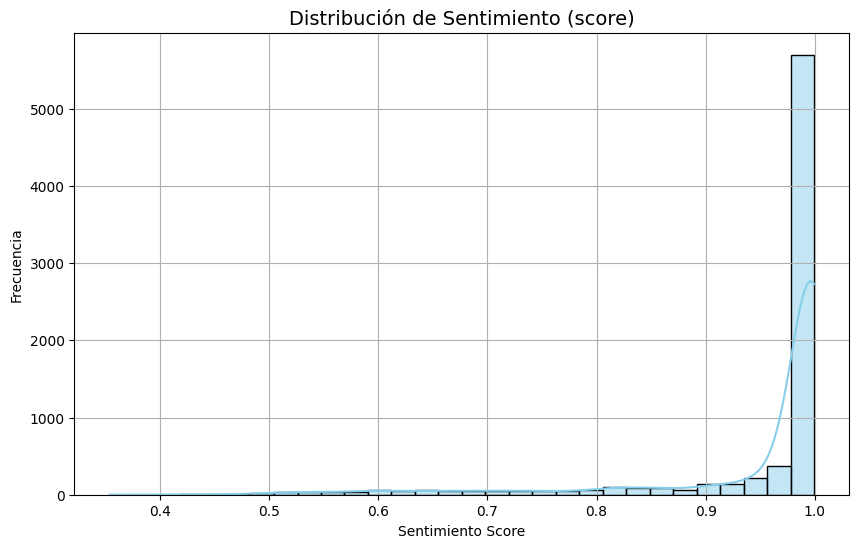

In [134]:
# Distribución de la variable sentimiento_score
plt.figure(figsize=(10, 6))
sns.histplot(hoteles_df['sentimiento_score'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Sentimiento (score)', fontsize=14)
plt.xlabel('Sentimiento Score')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


En general, la confianza del modelo con respecto a lo predicho, es muy buena. Casi todas las predicciones tienen un sentimiento_score muy alto (cerca de 1), lo cual indica que el modelo está muy seguro en la mayoría de los casos.

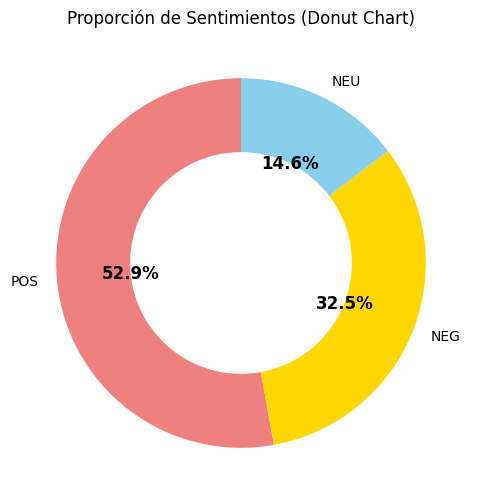

In [135]:
# Proporción de sentimientos a través de gráfico de anillo
# Conteo de sentimientos
sentimientos = hoteles_df['sentimiento'].value_counts()
labels = sentimientos.index
sizes = sentimientos.values
colors = ['lightcoral', 'gold', 'skyblue']  # negativo, neutral, positivo

# Gráfico de anillos
fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4)  # este valor crea el "hueco"
)

# Estilo
plt.setp(autotexts, size=12, weight="bold")
ax.set_title('Proporción de Sentimientos (Donut Chart)')
plt.show()


/tmp/ipython-input-136-1694307958.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




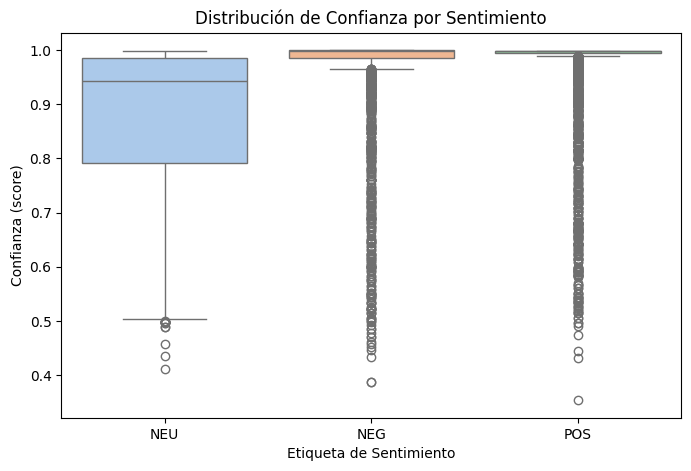

In [136]:
# Distribución de confianza por sentimiento
plt.figure(figsize=(8,5))
sns.boxplot(data=hoteles_df, x='sentimiento', y='sentimiento_score', palette='pastel')
plt.title('Distribución de Confianza por Sentimiento')
plt.ylabel('Confianza (score)')
plt.xlabel('Etiqueta de Sentimiento')
plt.show()

- NEU (Neutro):
Tiene más dispersión en la confianza. Algunas predicciones neutras tienen valores bajos, lo que sugiere incertidumbre en esas predicciones.

- NEG (Negativo) y POS (Positivo): La mayoría de los scores están cerca de 1, lo que indica alta confianza en estas clases. Los outliers  con baja confianza son reseñas más ambiguas o contradictorias.



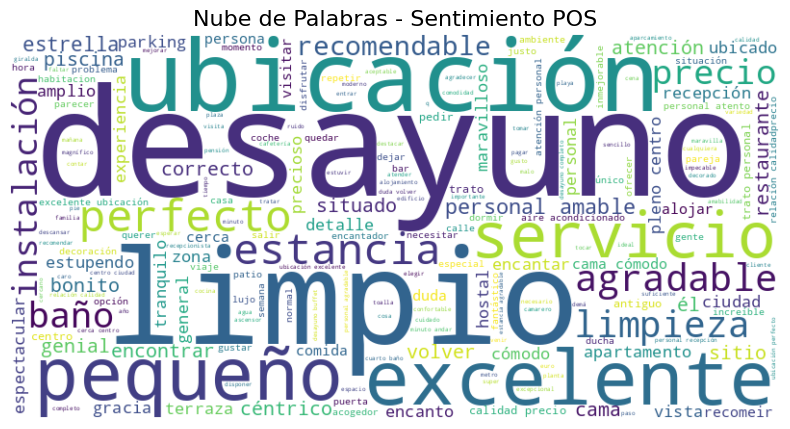

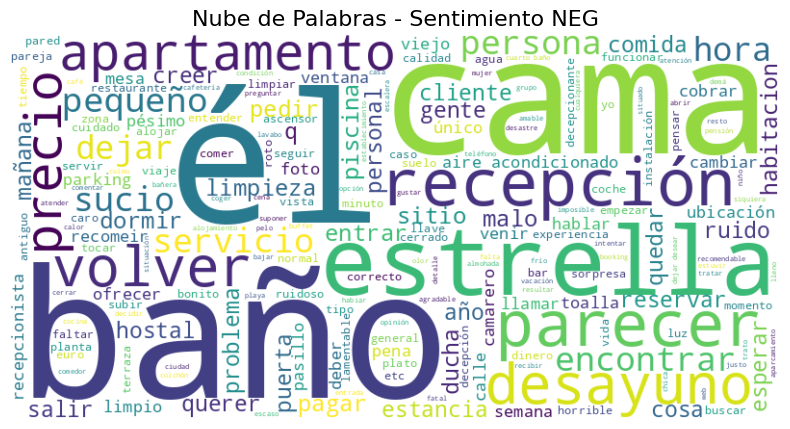

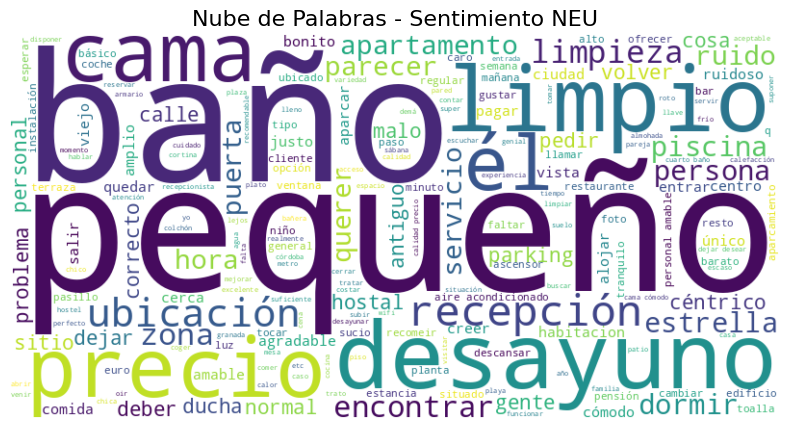

In [137]:
# WordCloud por sentimiento
def generar_wordcloud(texto, titulo):
    wordcloud = WordCloud(
        width=800, height=400, background_color='white',
        max_words=200, colormap='viridis'
    ).generate(" ".join(texto))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(titulo, fontsize=16)
    plt.show()

# Filtrar por sentimiento
sentimientos = ['POS', 'NEG', 'NEU']

for s in sentimientos:
    texto_filtrado = hoteles_df[hoteles_df['sentimiento'] == s]['review_procesada'].dropna()
    generar_wordcloud(texto_filtrado, f"Nube de Palabras - Sentimiento {s}")

El análisis exploratorio de datos permitió obtener una visión general y estructurada de la información proveniente de reseñas de alojamientos en Andalucía. A través del estudio de variables como las calificaciones (ratings), la frecuencia de menciones por hotel y la distribución de sentimientos, se identificaron patrones relevantes sobre la percepción de los usuarios y la calidad del servicio ofrecido.

Se destaca que la mayoría de las opiniones presentan una alta polarización hacia sentimientos positivos, lo que sugiere una experiencia globalmente satisfactoria por parte de los turistas. No obstante, también se identificaron segmentos con opiniones negativas que podrían indicar focos de mejora en determinados aspectos del servicio. A partir del análisis de frecuencia de palabras, bigramas, trigramas y adjetivos, se identifican los principales temas mencionados por los turistas en sus reseñas de alojamientos en Andalucía:

- Personal: Es el término más mencionado. En las reseñas positivas, el término servicio aparece con mayor frecuencia, y se destacan combinaciones como personal amable o personal atento. Esto evidencia un primer insight relevante: los visitantes valoran altamente el trato recibido, lo que convierte a la atención del personal en un diferencial clave a preservar.

- Desayuno: Es la segunda palabra más repetida en el corpus. Si bien no se asocia de forma masiva a adjetivos como “rico” o “exquisito” (salvo menciones puntuales), el desayuno es un aspecto valorado principalmente en las reseñas positivas, lo que lo convierte en otro factor a destacar y mantener.

- Baño y cama: Son elementos que aparecen con mayor frecuencia en reseñas negativas y neutras. Siendo servicios básicos e indispensables en la experiencia de hospedaje, es necesario prestar atención a estos puntos para evitar que afecten negativamente la percepción general del alojamiento.

- Ubicación: Es uno de los aspectos más positivamente valorados por los usuarios. La expresión excelente ubicación es uno de los bigramas más frecuentes, lo que indica que la cercanía al centro o a puntos de interés es altamente apreciada por los turistas.

- Precio: Tiene mayor presencia en las reseñas neutras, donde predomina la expresión relación precio calidad, lo que sugiere una percepción generalmente equilibrada por parte de los usuarios (sin que el precio sea ni un beneficio diferencial ni una decepción). En las reseñas negativas, también se menciona el precio, y aparece el adjetivo caro en menor medida.

- Limpieza: Se destaca en las reseñas positivas, con la palabra limpio sobresaliendo frente a sucio. Este factor también es mencionado en reseñas neutras, lo que refuerza la importancia de mantener altos estándares de limpieza como parte de la experiencia esperada por los turistas.

- Tamaño del espacio: La palabra pequeño aparece tanto en reseñas positivas como neutras. Aunque podría tener una connotación negativa, en este análisis no se observa que sea un factor decisivo en la percepción general del hospedaje.

- Adjetivos utilizados: Predominan los adjetivos positivos sobre los negativos. Entre los más frecuentes se encuentran: buen, mejor, limpio, bueno, bonito, cómodo, correcto, tranquilo, excelente, recomendable, agradable, perfecto, amable, grande, céntrico y amplio. En cambio, entre los negativos aparecen en menor cantidad: peor, antiguo, pequeño, sucio, ruidoso y malo.

Estos hallazgos brindan un insumo valioso para la formulación de estrategias desde el sector público, orientadas a incentivar el turismo, reforzar la calidad de los alojamientos y diseñar campañas segmentadas según las preferencias y experiencias del visitante.



# 🧠 Modelo predictivo con red neuronal

### vectorización (TF-IDF)

In [151]:
#Vectorización con TF-IDF
# Texto y etiquetas
X_text = hoteles_df['review_procesada']
y_label = hoteles_df['sentimiento']

# Codificación de etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y_label)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X_text).toarray()

# División
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Calcular pesos
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


### Creación y entrenamiento del modelo

In [152]:
# Modelo con regularización
model = models.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# Compilación
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callback para evitar sobreajuste
early_stop = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')

# Entrenamiento
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5260 - loss: 1.2043 - val_accuracy: 0.7629 - val_loss: 0.7599
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7843 - loss: 0.7819 - val_accuracy: 0.7925 - val_loss: 0.7113
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8692 - loss: 0.6460 - val_accuracy: 0.7933 - val_loss: 0.7352
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9076 - loss: 0.5453 - val_accuracy: 0.7785 - val_loss: 0.8128
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9346 - loss: 0.4825 - val_accuracy: 0.8015 - val_loss: 0.7886


### Evaluación del modelo

In [153]:
# Evaluación sobre test
loss, acc = model.evaluate(X_test, y_test)
print(f"🔍 Accuracy en test: {acc:.4f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Reporte de clasificación
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7969 - loss: 0.7427
🔍 Accuracy en test: 0.8063
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         NEG       0.81      0.83      0.82       495
         NEU       0.49      0.62      0.55       223
         POS       0.93      0.84      0.88       805

    accuracy                           0.81      1523
   macro avg       0.74      0.76      0.75      1523
weighted avg       0.82      0.81      0.81      1523



El modelo alcanzó una accuracy general del 81%, con una pérdida aceptable de 74%.

Tiene muy buen desempeño en las clases POS (F1-score: 0.88) y NEG (F1-score: 0.82), lo que indica que reconoce con precisión los sentimientos extremos.

El mayor desafío es la clase NEU, con un F1-score bajo (0.55), lo que sugiere confusión entre neutral y las otras clases.

El macro promedio (0.75) refleja un buen balance general, pero con margen de mejora en la clase minoritaria

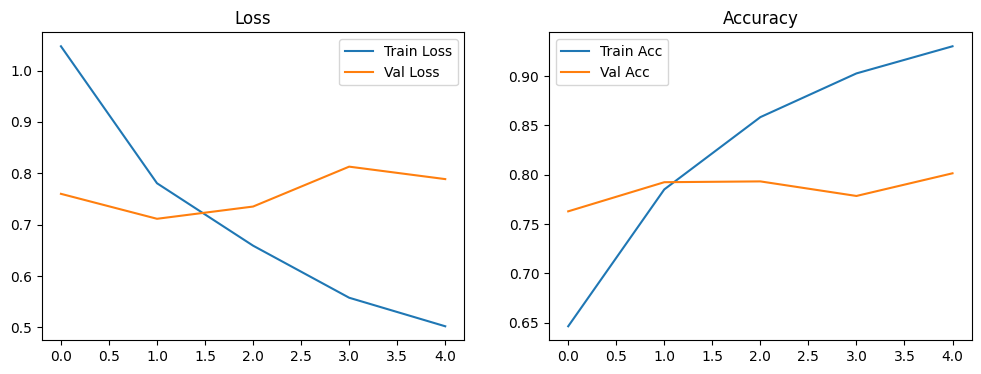

In [154]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.show()


El modelo logra una alta precisión en entrenamiento (93%) en pocas épocas, lo que indica una rápida capacidad de aprendizaje.

La accuracy de validación se mantiene estable en torno al 80%, mostrando un buen rendimiento general sobre datos no vistos.

Aunque la pérdida en validación (val_loss) tiene una leve tendencia a subir, no se observa un sobreajuste severo en estas primeras épocas.

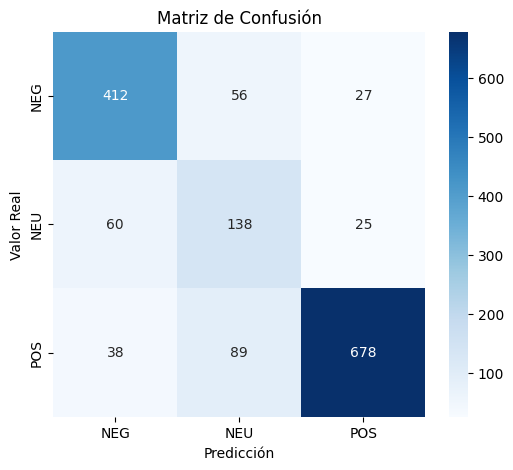

In [155]:
cm = confusion_matrix(y_test, y_pred_labels)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()


La matriz de confusión muestra que el modelo clasifica correctamente la mayoría de las reseñas positivas (678) y negativas (412), pero tiene más dificultad con las neutras, confundiendo varias con positivas o negativas.

### Prueba con nuevos ejemplos

In [157]:
# Función de pruebas con nuevos ejemplos
def predecir_nuevas_reseñas(modelo, vectorizer, label_encoder, nuevas_reseñas):
    # Preprocesamiento similar al dataset original
    nuevas_reseñas = [r.lower() for r in nuevas_reseñas]  # simple limpieza
    X_nuevo = vectorizer.transform(nuevas_reseñas).toarray()

    # Predicción
    y_pred_probs = modelo.predict(X_nuevo)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

    # Decodificar etiquetas
    etiquetas = label_encoder.inverse_transform(y_pred_labels)
    return etiquetas, y_pred_probs


In [163]:
# Nuevas reseñas de prueba
nuevas_reseñas = [
    "La habitación espectacular y el personal muy amable.",
    "No volvería jamás, el servicio fue pésimo y sucio.",
    "Fue una estadía normal, ni buena ni mala."
]

# Predecir
etiquetas_pred, probabilidades = predecir_nuevas_reseñas(model, vectorizer, le, nuevas_reseñas)

# Mostrar resultados
for i, texto in enumerate(nuevas_reseñas):
    print(f"🔍 Reseña: {texto}")
    print(f"➡️  Sentimiento Predicho: {etiquetas_pred[i]} (Prob: {probabilidades[i].max():.2f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
🔍 Reseña: La habitación espectacular y el personal muy amable.
➡️  Sentimiento Predicho: POS (Prob: 0.83)

🔍 Reseña: No volvería jamás, el servicio fue pésimo y sucio.
➡️  Sentimiento Predicho: NEG (Prob: 0.93)

🔍 Reseña: Fue una estadía normal, ni buena ni mala.
➡️  Sentimiento Predicho: NEU (Prob: 0.50)



Los ejemplos analizados muestran que el modelo logra identificar correctamente los sentimientos expresados en distintos tipos de reseñas: clasifica con alta confianza una opinión positiva y otra negativa, y también detecta adecuadamente una reseña neutra, aunque con menor probabilidad.

# 📌 Conclusiones

Este proyecto analizó más de 7.600 reseñas de hoteles de Andalucía con el objetivo de obtener información clave desde la perspectiva de los turistas, y generar herramientas analíticas para apoyar estrategias de incentivo al turismo.

Se realizó una limpieza exhaustiva del texto y un análisis exploratorio que permitió identificar temáticas recurrentes como el trato del personal, el desayuno, la ubicación y la limpieza. A partir de ello, se destacaron insights valiosos: por ejemplo, el personal es el aspecto más mencionado y valorado, mientras que los aspectos relacionados al baño y la relación precio-calidad aparecen con mayor frecuencia en comentarios negativos o neutros.

Se desarrolló un modelo de clasificación de sentimientos basado en una red neuronal entrenada sobre representaciones TF-IDF de las reseñas. A pesar del desbalanceo de clases, el modelo alcanzó una precisión del 81% sobre el conjunto de prueba. Además, la matriz de confusión mostró una buena capacidad para distinguir opiniones positivas y negativas, aunque con un margen de mejora en la detección de sentimientos neutros.

Finalmente, se implementó un sistema de predicción sobre nuevas reseñas que demostró una interpretación coherente con la intención expresada en los textos. Esto permite escalar el análisis a reseñas futuras y evaluar automáticamente la percepción turística.

Este análisis habilita a la Secretaría de Turismo a tomar decisiones basadas en la voz del visitante, identificar fortalezas consolidadas (como el trato humano y la ubicación) y atender áreas de mejora. También sienta las bases para desarrollar tableros interactivos y sistemas automáticos de monitoreo de reputación turística.